In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('../style/style-formal.mplstyle')

### AutoFL example quality

In [2]:
qualities = pd.read_csv("resources/survey_bug_explanations.csv")
qualities["FL Recall"] = (qualities["GT Contained"]/qualities["GT # Fix Locations"]).round(2)
qualities["Accurate"] = qualities["Accurate"].astype(bool)
qualities["Imprecise"] = qualities["Imprecise"].astype(bool)
qualities["Wrong"] = (~qualities["Accurate"] & qualities["Imprecise"])
qualities["FL Quality"] = qualities["FL Recall"].apply(lambda r: "Correct" if r == 1.0 else "Partial" if r > 0 else "Wrong")
qualities = qualities[qualities["Problem"] != "tutorial"]
qualities["LLM"] = qualities["LLM"].apply(lambda n: "3.5" if n == 3.5 else "4")
qualities = qualities.replace("Wrong+", "Wrong")
qualities = qualities.replace("NE", "N/A")
qualities = qualities.replace("Partial+", "Partial")
qualities

,Problem,LLM,Explanation,GT # Fix Locations,GT Contained,Test Description,Error Description,Code Intention,NL Fix Suggestion,Fix Code Suggestion,Accurate,Imprecise,FL Recall,Wrong,FL Quality
6,pandas_22,3.5,1,3,2,N/A,Correct,Correct,Correct,N/A,True,False,0.67,False,Partial
7,pandas_22,3.5,2,3,1,Correct,Correct,Correct,Partial,N/A,True,False,0.33,False,Partial
8,pandas_22,3.5,3,3,1,N/A,Correct,Correct,Partial,N/A,True,False,0.33,False,Partial
9,pandas_22,3.5,4,3,1,N/A,Correct,Correct,Partial,Partial,True,False,0.33,False,Partial
10,pandas_22,3.5,5,3,1,N/A,Correct,N/A,Partial+Vague,N/A,True,False,0.33,False,Partial
11,pandas_22,4,1,3,1,N/A,Correct,Correct,Partial,N/A,True,False,0.33,False,Partial
12,pandas_22,4,2,3,3,N/A,Correct,Correct,Partial+Vague,N/A,True,False,1.00,False,Correct
13,pandas_22,4,3,3,1,Correct,Correct,Correct,N/A,N/A,True,False,0.33,False,Partial
14,pandas_22,4,4,3,1,N/A,Correct,Correct,Partial,N/A,True,False,0.33,False,Partial
15,pandas_22,4,5,3,2,Correct,Correct,N/A,N/A,N/A,True,False,0.67,False,Partial


In [3]:
models = list(qualities.LLM.drop_duplicates())
bugs = list(qualities["Problem"].drop_duplicates())
bugs

['pandas_22', 'pandas_142', 'pandas_152', 'pandas_158']

In [4]:
def survey(results, category_names, title=None, savepath=None):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    if "N/A" not in category_names:
        category_colors = plt.get_cmap('RdYlGn')(
            np.linspace(0.15, 0.85, data.shape[1]))
    else:
        category_colors = np.vstack([
            plt.get_cmap('Greys')(np.linspace(0.3, 0.3, 1)),
            plt.get_cmap('RdYlGn')(
                np.linspace(0.15, 0.85, data.shape[1] - 1))])
        #category_colors = [ ] + category_colors
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.8,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'black'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center',
                        color=text_color)
    ax.legend(ncol=len(category_names) if len(category_names) <= 4 else 3,
              bbox_to_anchor=(1.01, 0), loc='upper right', fontsize='medium')
    plt.grid(None)
    if title is not None:
        plt.title(title)
    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")

    plt.show()
    return fig, ax

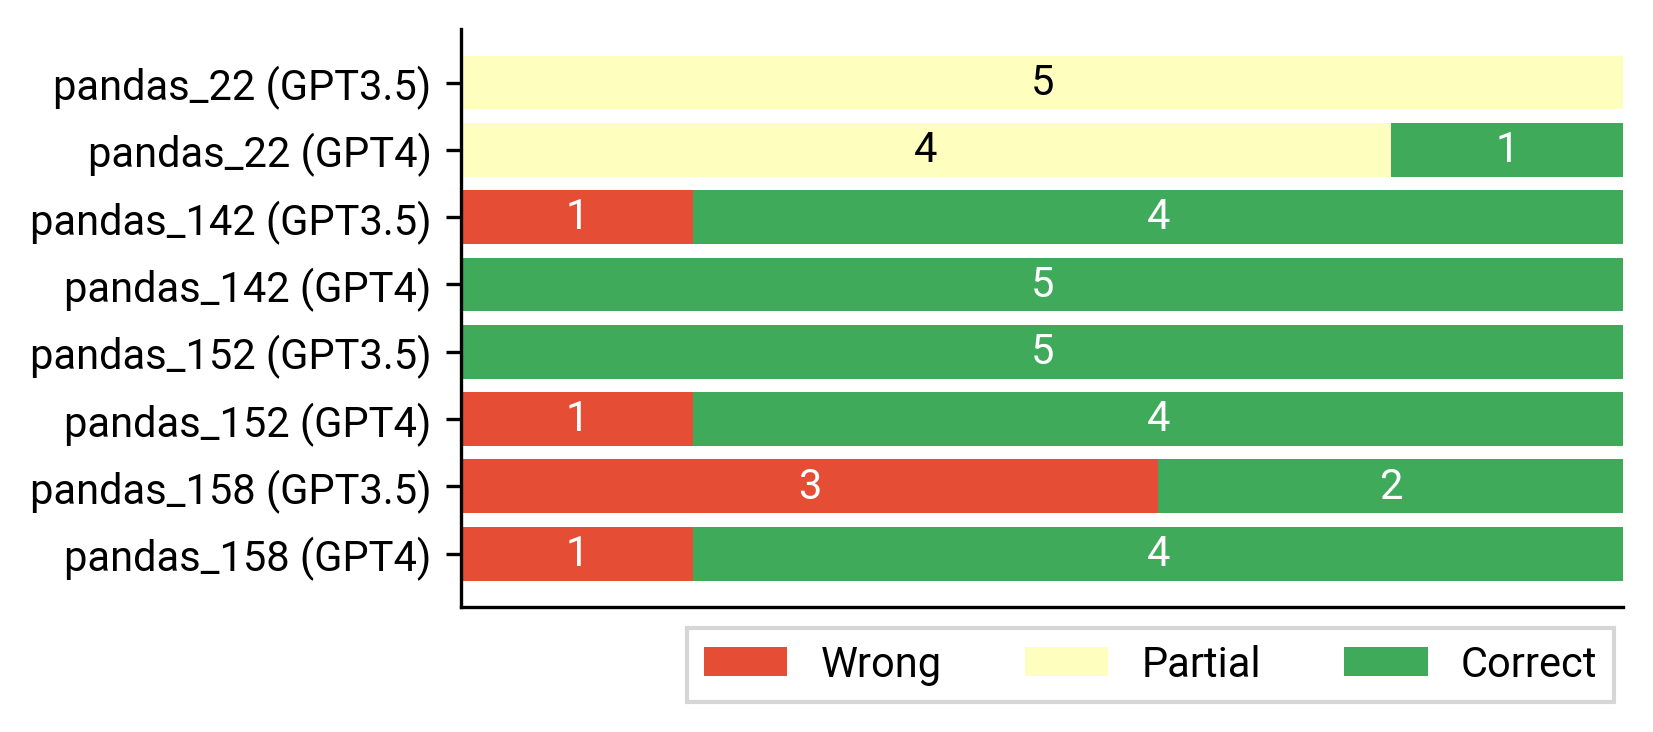

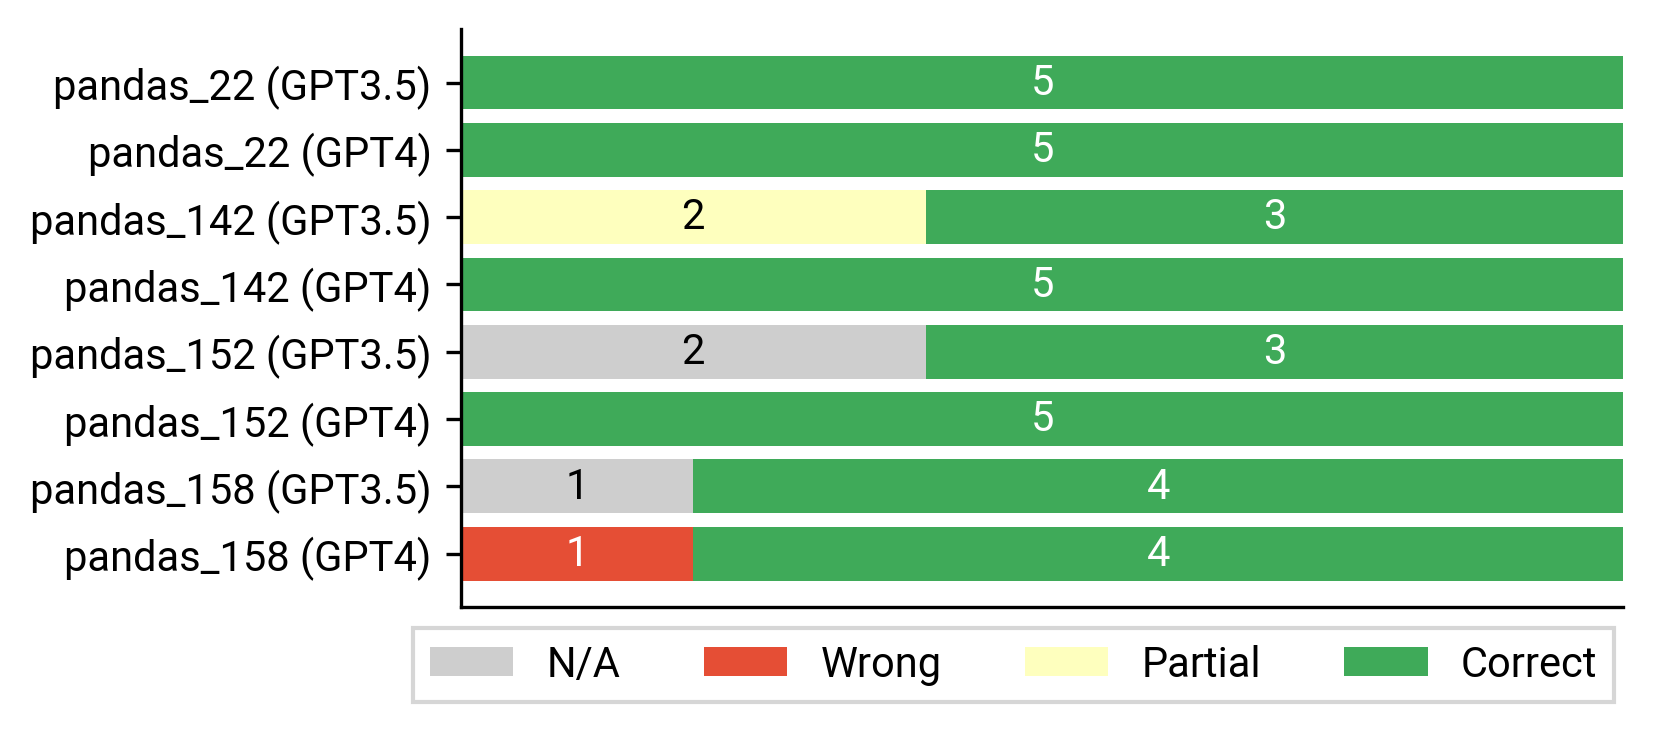

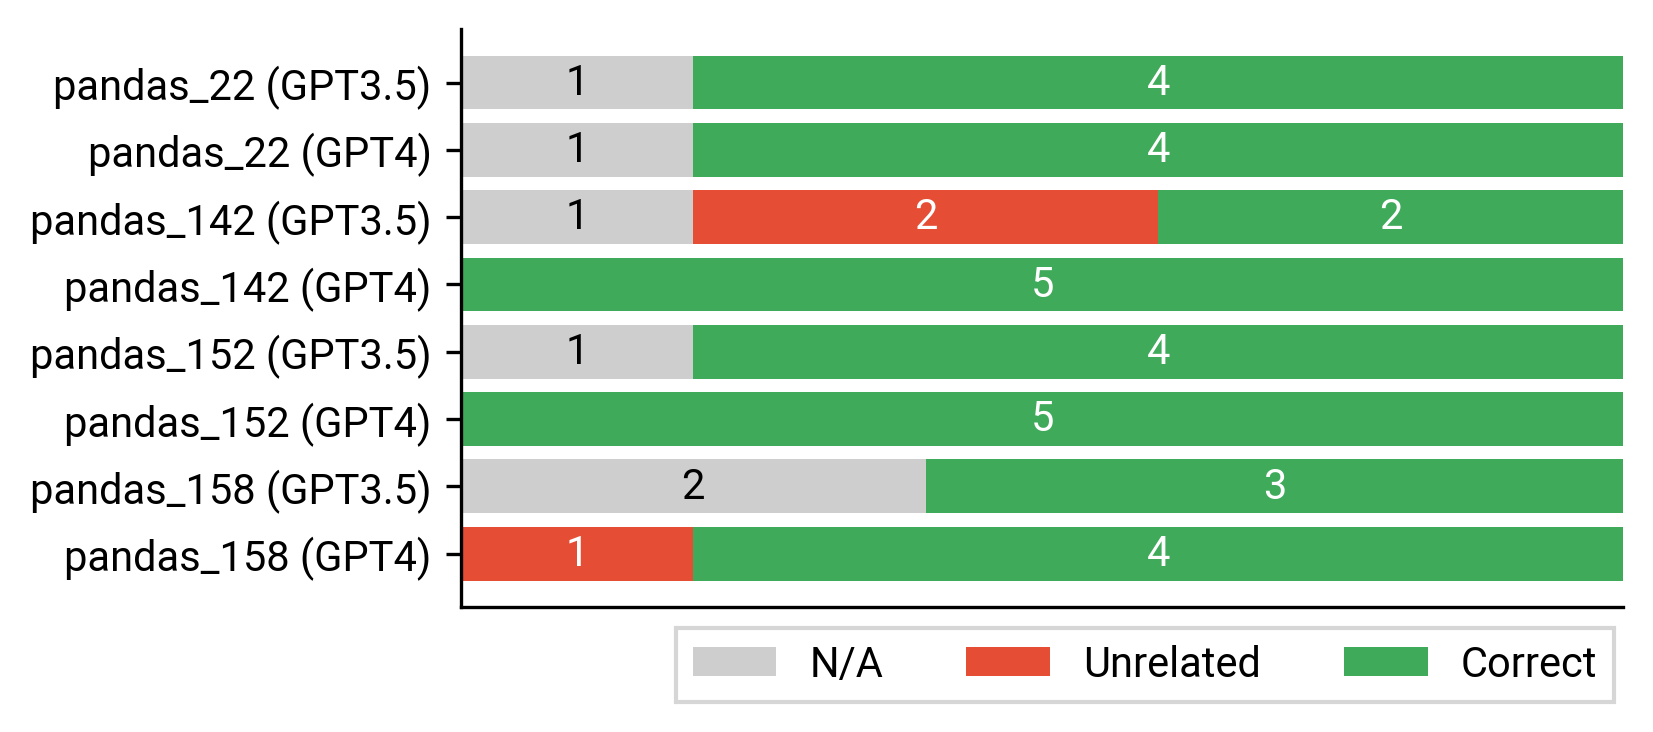

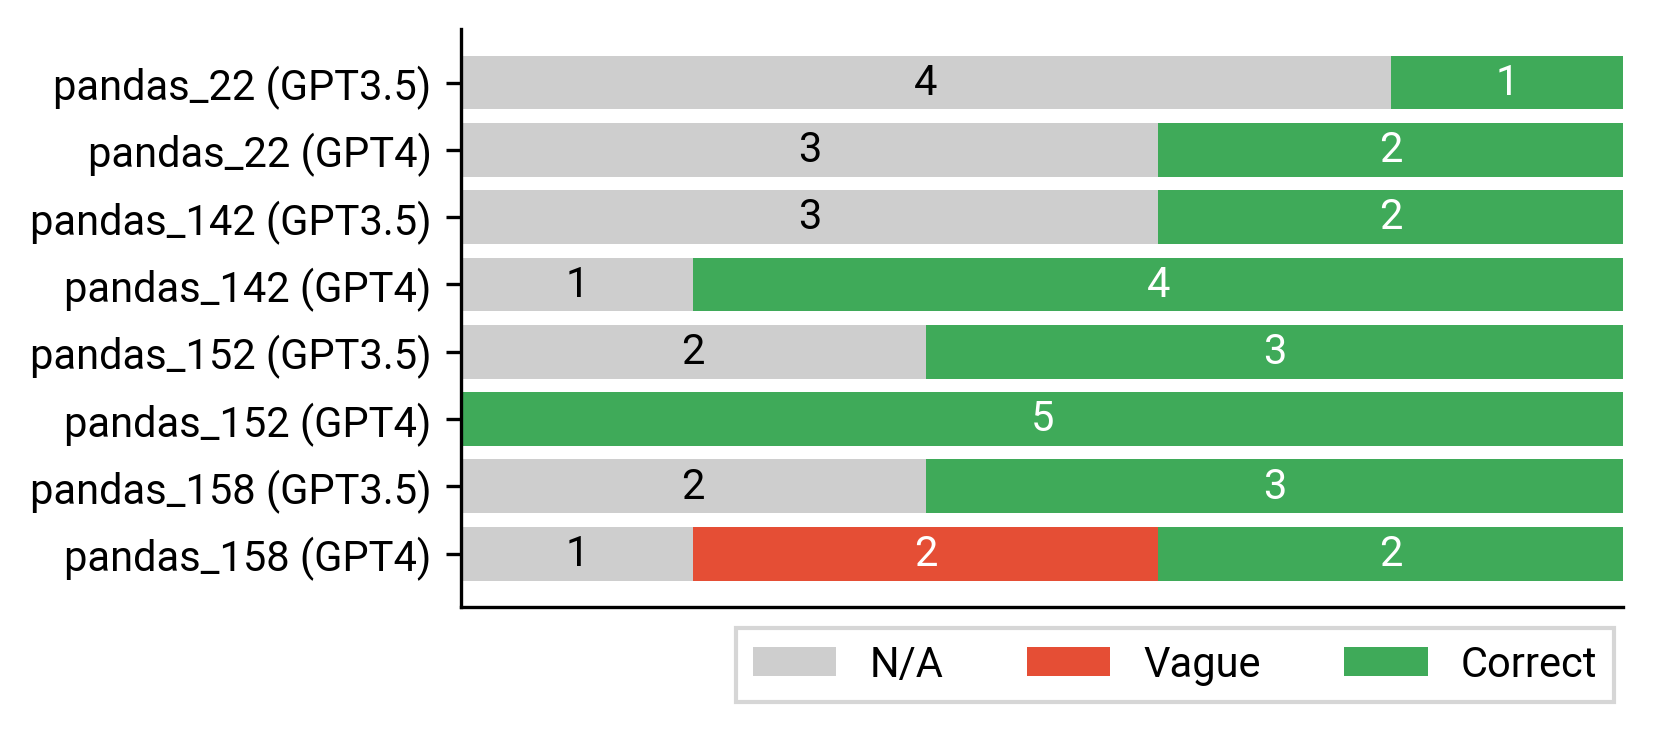

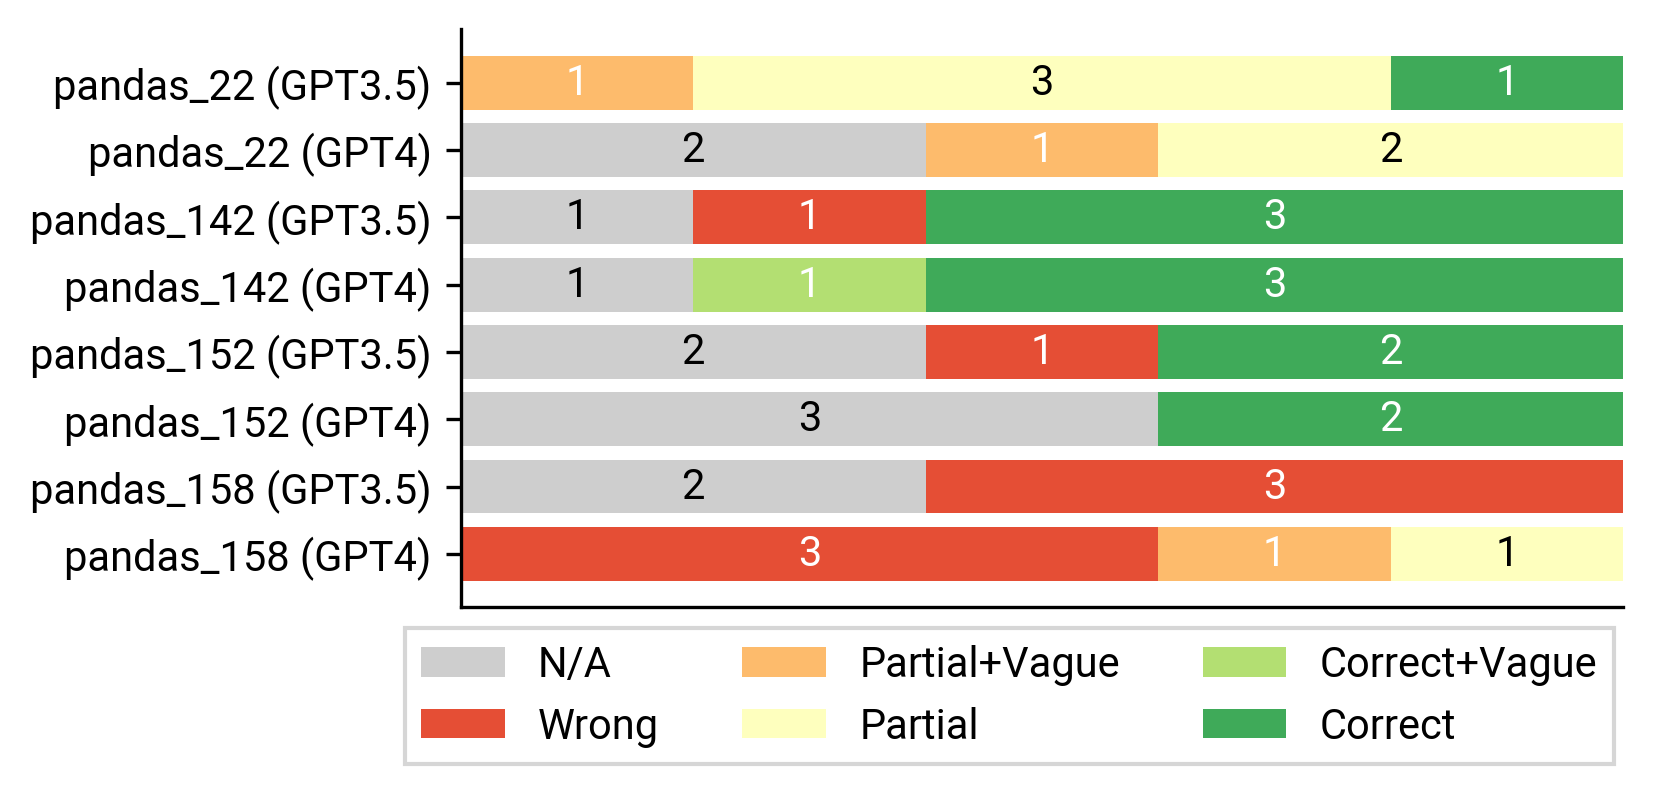

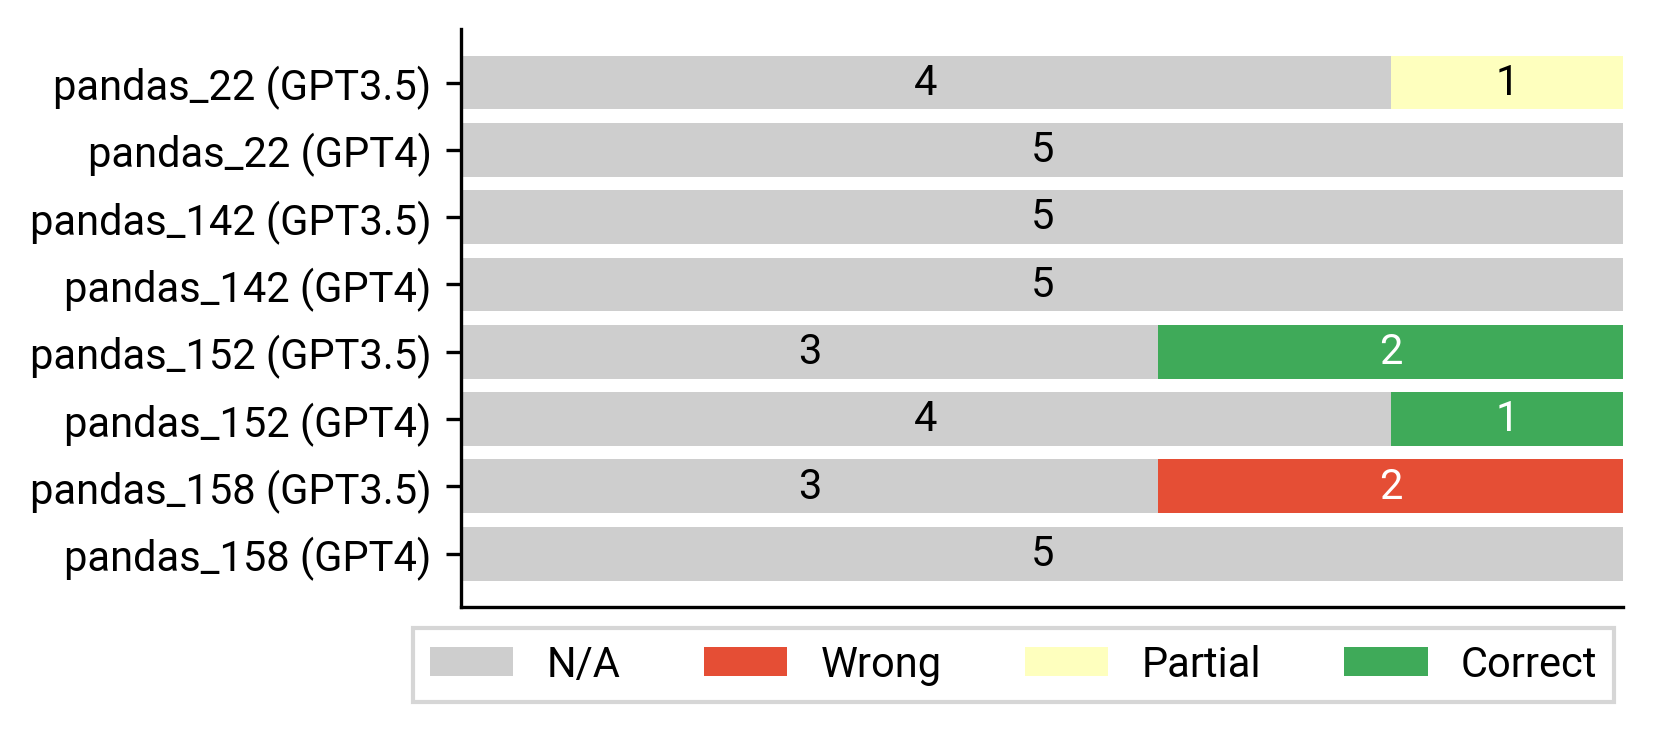

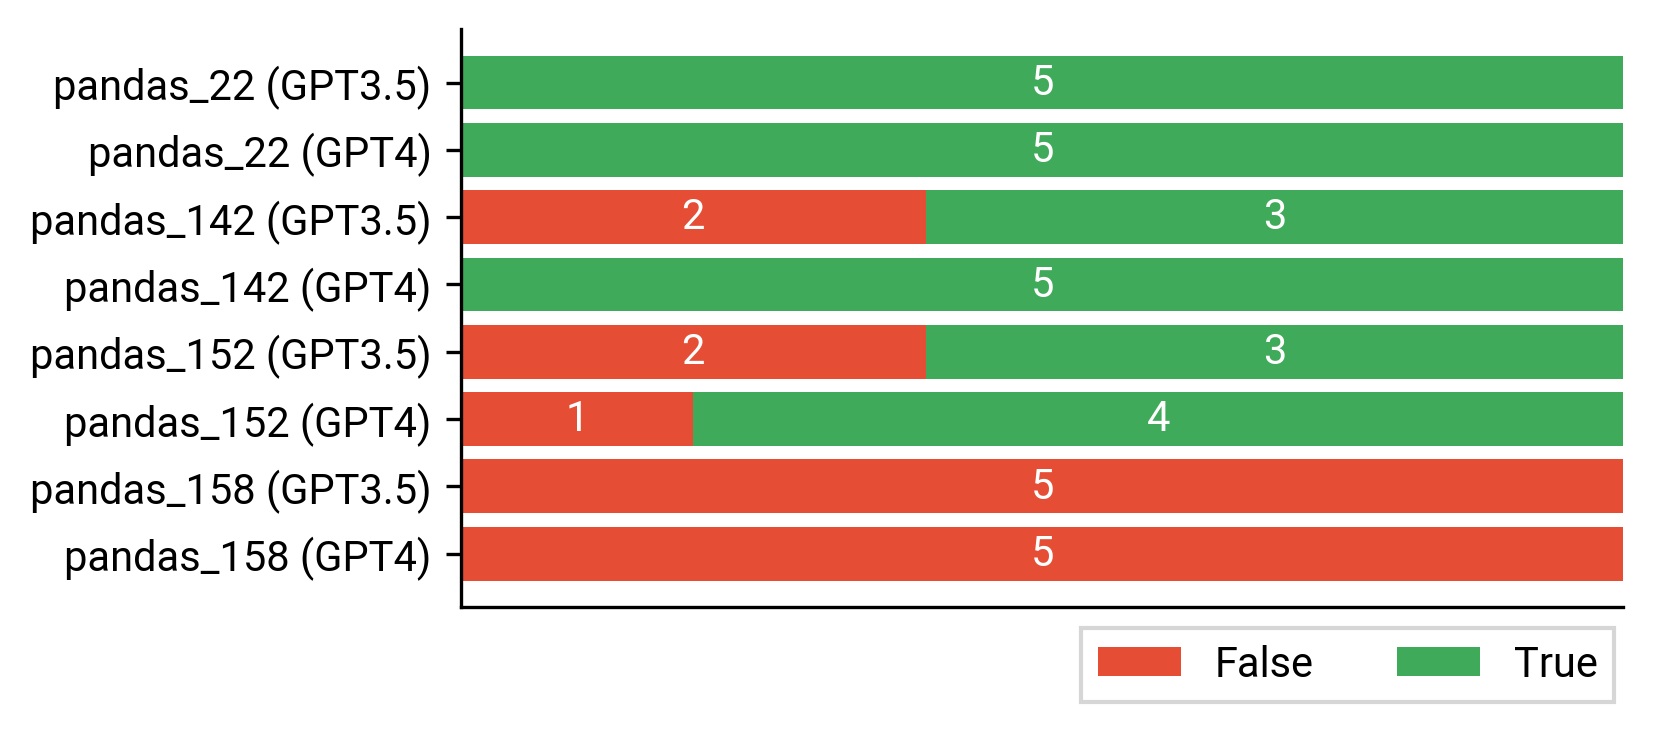

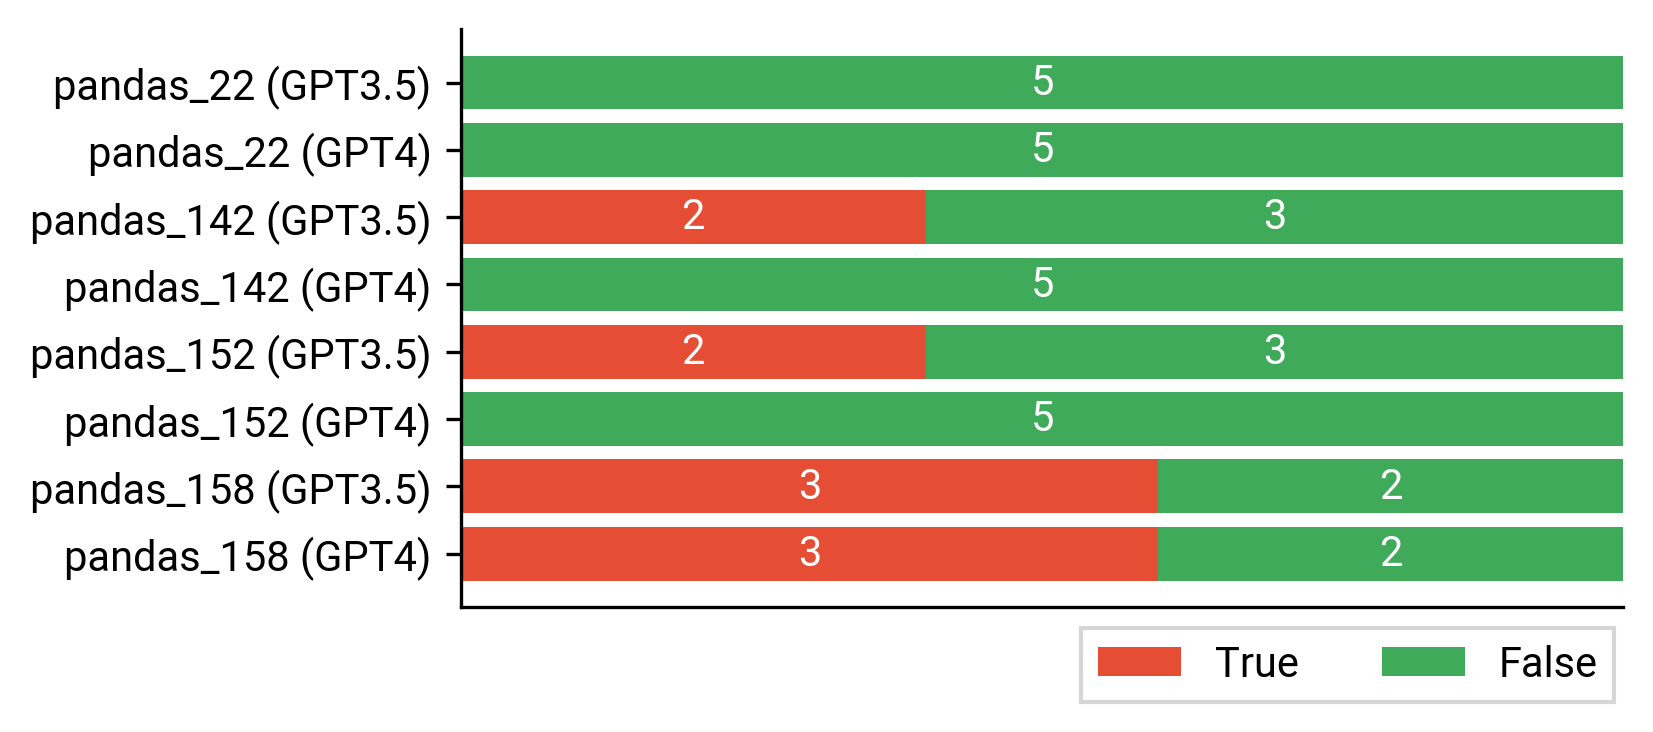

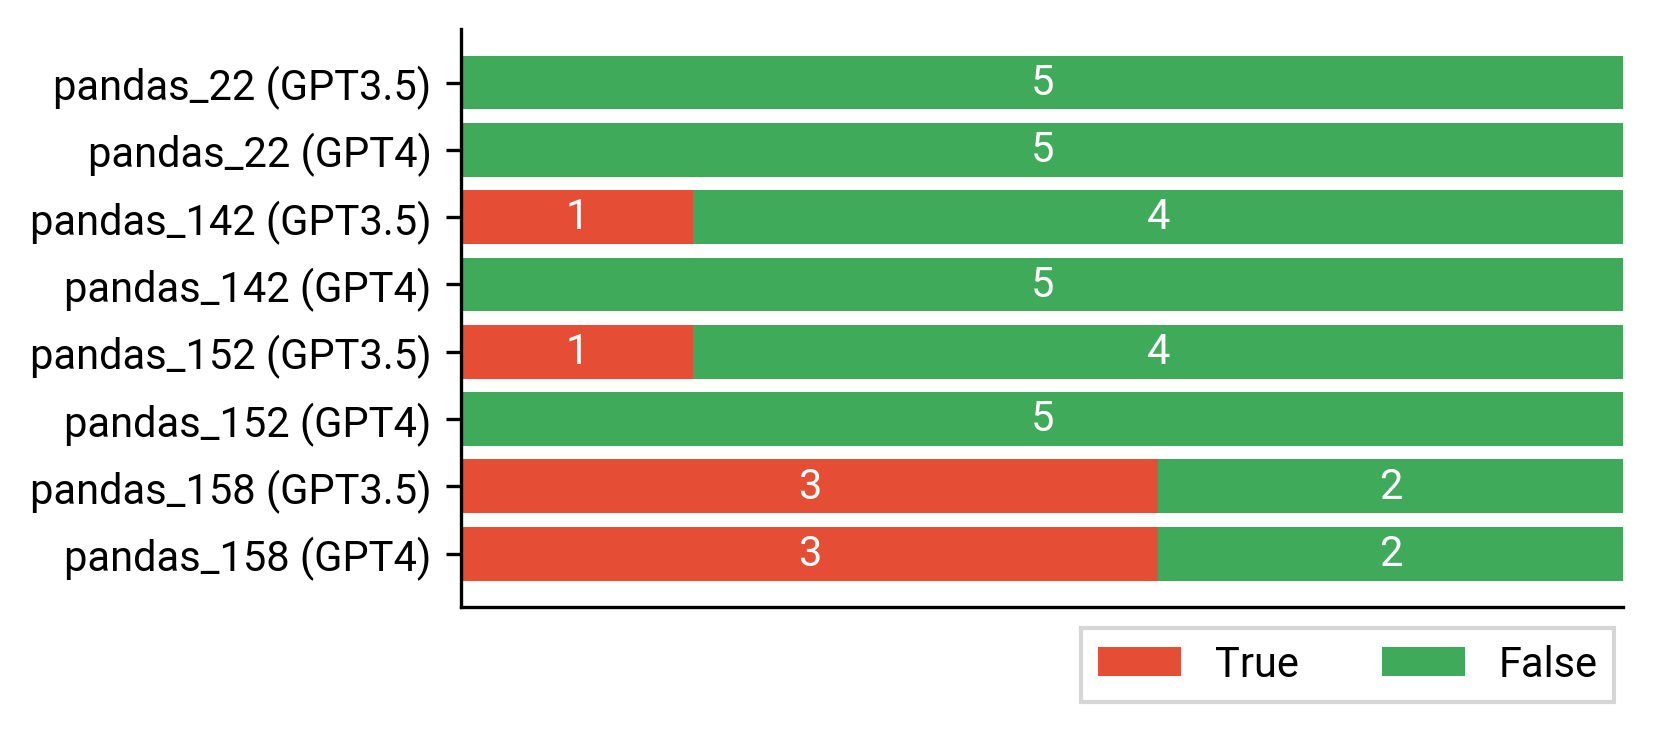

In [5]:
value = {
    True: 5,
    "Correct": 5,
    "Correct+Vague": 4.5,
    "Partial": 4,
    "Partial+Vague": 3.5,
    "Vague": 3,
    "Unrelated": 2,
    "Wrong": 1,
    "N/A": 0,
    False: 0
}

for column in ["FL Quality", "Error Description", "Code Intention", "Test Description", "NL Fix Suggestion", "Fix Code Suggestion", "Accurate", "Imprecise", "Wrong"]:
    category_names = set(qualities[column])
    if column in ["Imprecise", "Wrong"]:
        category_names = sorted(category_names, key=lambda c: -value[c])
    else:
        category_names = sorted(category_names, key=lambda c: value[c])
    results = {
        f"{bug} (GPT{model})": [
            (qualities[(qualities["Problem"] == bug) & (qualities["LLM"] == model)][column] == answer).sum()
            for answer in category_names
        ]
        for bug in bugs for model in models
    }
    survey(results, category_names, savepath=f"./figures/RQ4_autofl_quality_{column.replace(' ', '')}.pdf")

### Multiple choice questions

In [6]:
answers = pd.read_csv("resources/survey_answers.csv")
answers

,ParticipantID,Problem,Difficulty,UsedFL,WantedExplanation,UsedExplanation,WhichLLM,NewErrorMessage,WantedNewExplanation,ExplMatchedDevPatch,CouldDistinguishCorrectExpl
0,chicken,tutorial,3.0,True,True,True,3.5,False,NaN,Partial,False
1,lion,tutorial,2.0,False,False,False,NaN,False,NaN,NaN,NaN
2,eagle,tutorial,2.0,False,False,False,NaN,False,NaN,False,NaN
3,turtle,tutorial,2.0,True,True,True,Both,False,NaN,True,True
4,deer,tutorial,2.0,True,True,True,Both,False,NaN,Partial,False
5,koala,tutorial,1.0,True,True,True,3.5,False,NaN,Partial,True
6,tiger,tutorial,3.0,True,True,True,3.5,True,False,Partial,True
7,dolphin,tutorial,3.0,True,True,True,4,False,NaN,Partial,False
8,elephant,tutorial,1.0,True,True,True,3.5,False,NaN,True,True
9,dragon,tutorial,3.0,True,True,True,3.5,False,NaN,Partial,False


{1.0: 9, 2.0: 10, 3.0: 13, 4.0: 6, 5.0: 9}
{False: 9, True: 39}
{False: 5, True: 39}
{False: 9, True: 39}
{'3.5': 17, '4': 9, 'Both': 17}
{False: 26, True: 21}
{False: 3, True: 18}
{'False': 12, 'Partial': 23, 'True': 12}
{False: 17, True: 26}


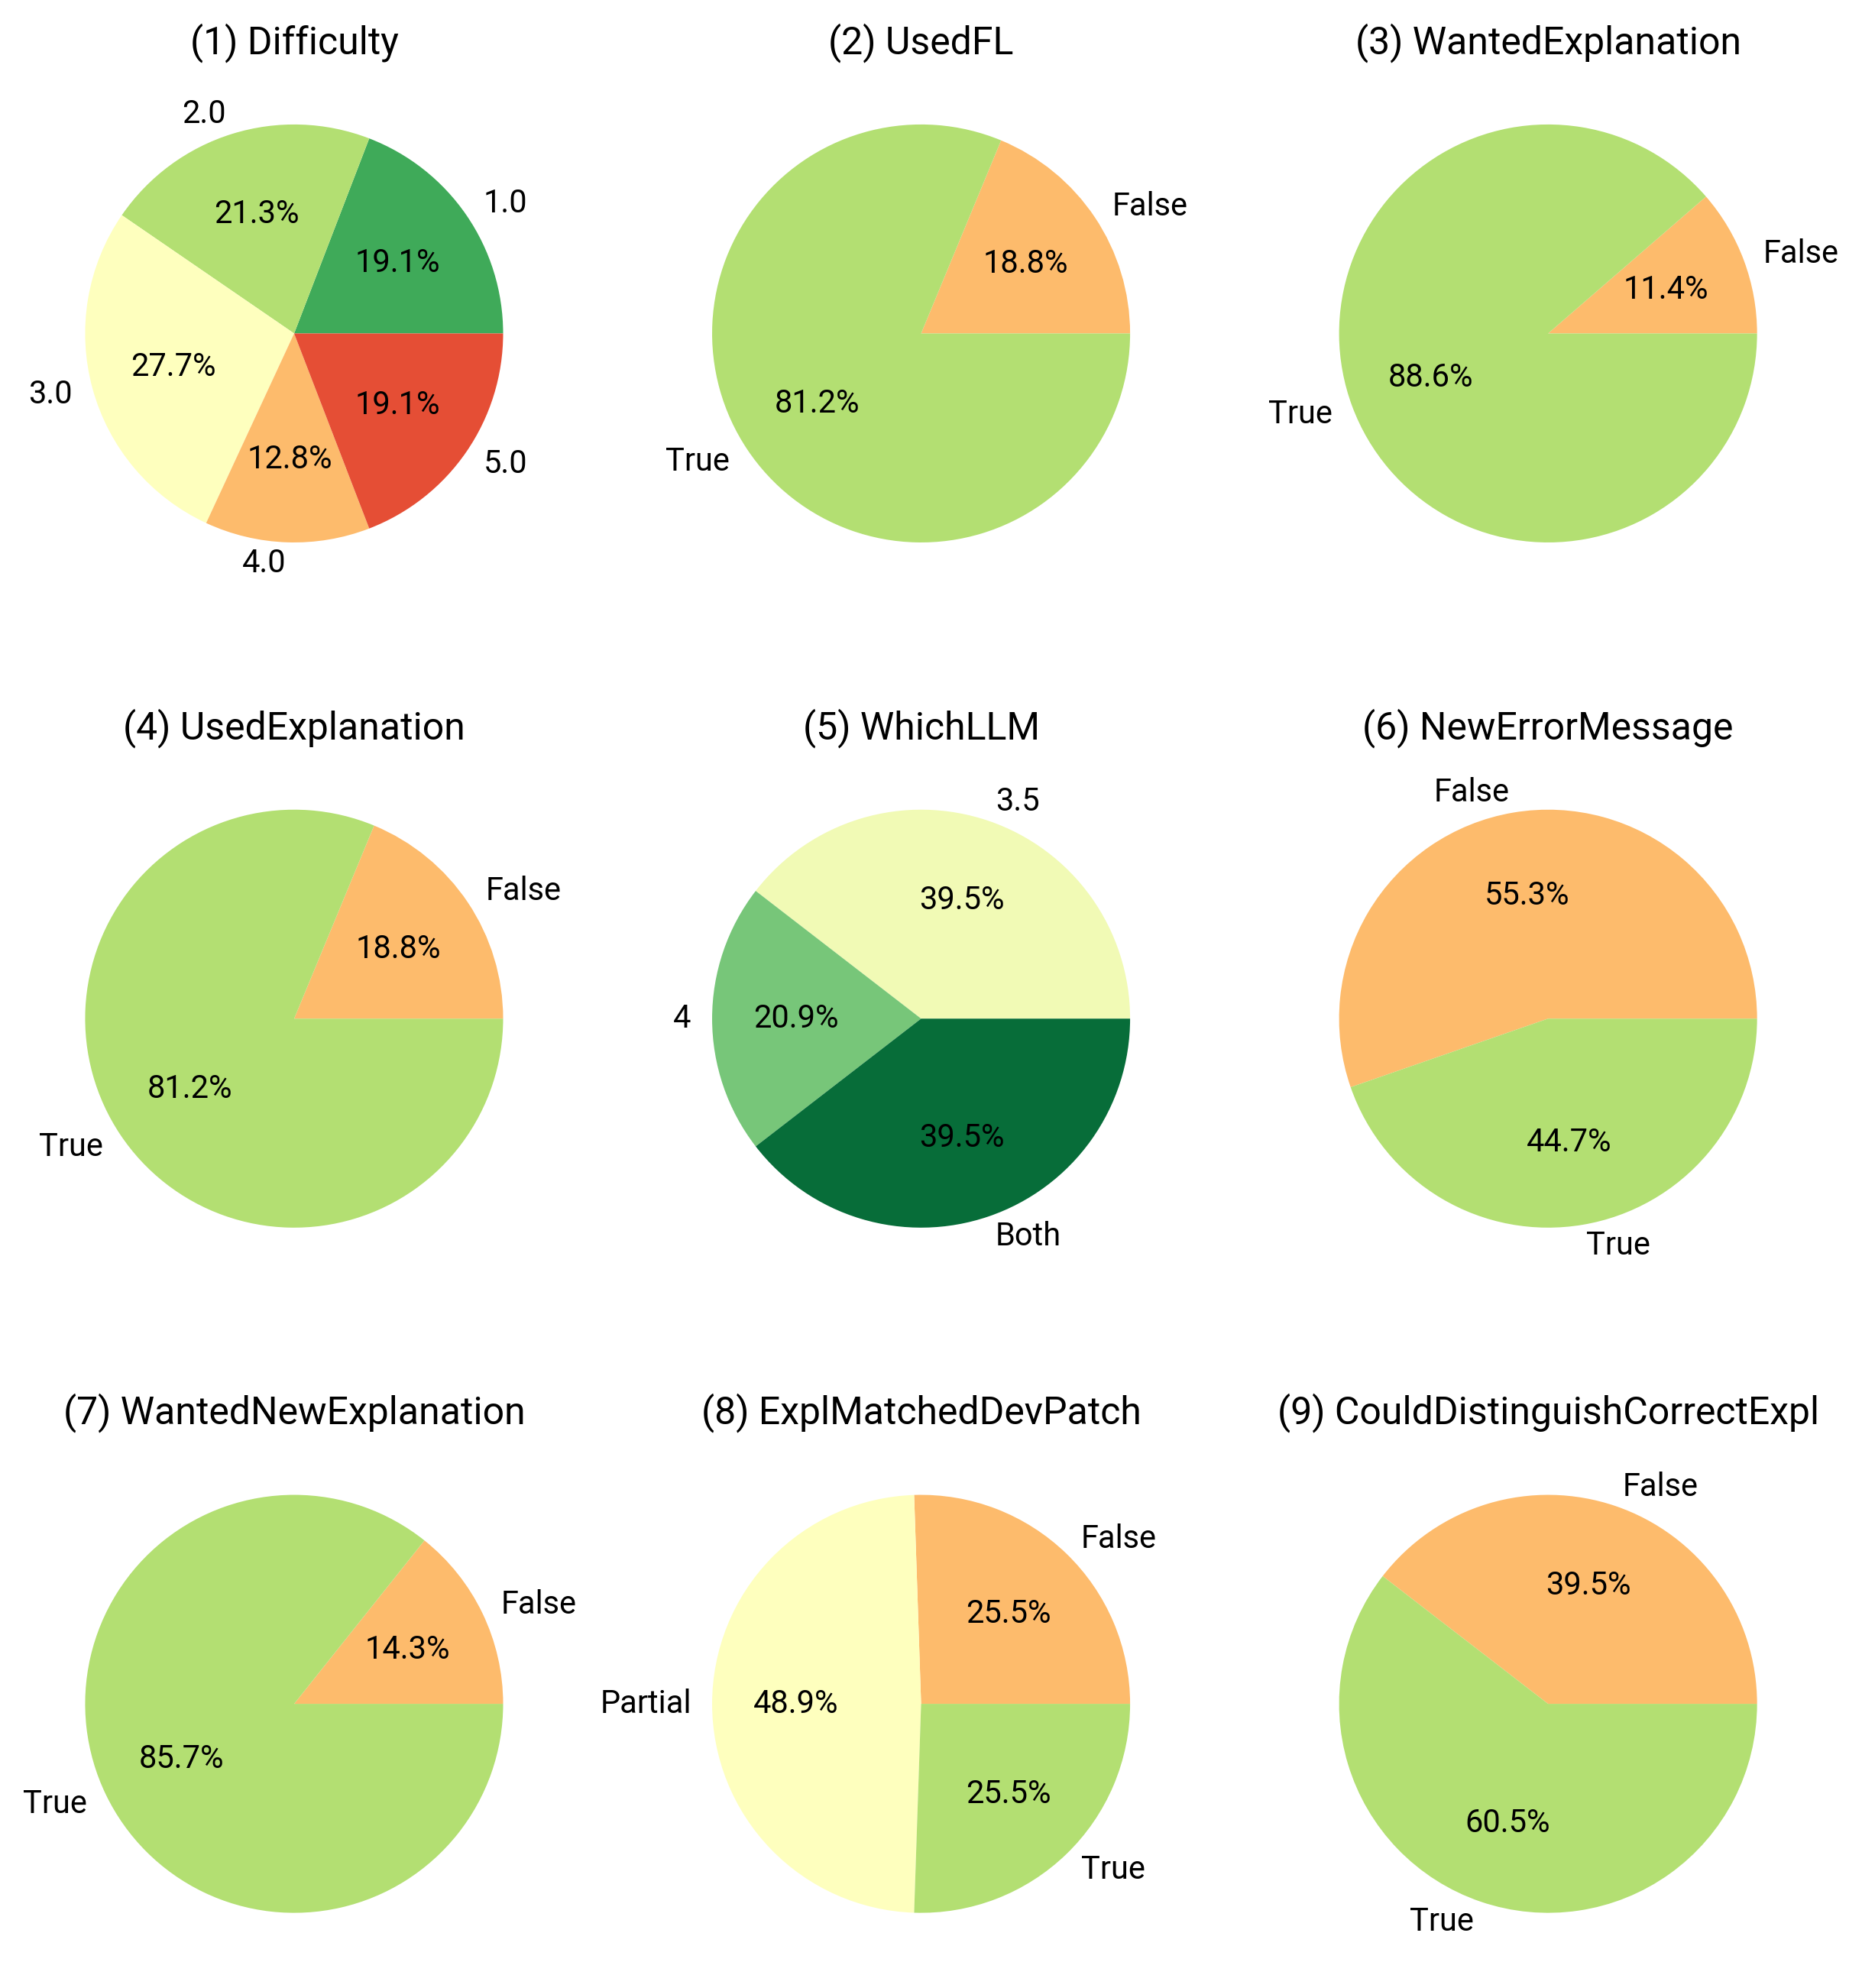

In [7]:
survey_columns = ["Difficulty", "UsedFL", "WantedExplanation", "UsedExplanation", "WhichLLM", "NewErrorMessage", "WantedNewExplanation", "ExplMatchedDevPatch", "CouldDistinguishCorrectExpl"]
plt.figure(figsize=(10, 11))
likert_cmap = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 5))
TF_cmap = plt.get_cmap('coolwarm')(np.linspace(0.15, 0.85, 3))
llm_cmap = plt.get_cmap('YlGn')(np.linspace(0.15, 0.85, 3))
colors = {
    "1.0": likert_cmap[4],
    "2.0": likert_cmap[3],
    "3.0": likert_cmap[2],
    "4.0": likert_cmap[1],
    "5.0": likert_cmap[0],
    "3.5": llm_cmap[0],
    "4": llm_cmap[1],
    "Both": llm_cmap[2],
    "True": likert_cmap[3],
    "Partial": likert_cmap[2],
    "False": likert_cmap[1],
}

for i, column in enumerate(survey_columns):
    value_counts = answers[column].value_counts().to_dict()
    value_counts = {k:value_counts[k] for k in sorted(value_counts)}
    print(value_counts)
    plt.subplot(3, 3, i+1)
    plt.title(f"({i+1}) {column}")
    plt.pie(value_counts.values(), labels=value_counts.keys(), autopct='%1.1f%%',
            colors=[colors[str(k)] for k in value_counts])
plt.savefig(f"./figures/RQ4_survey_answers.pdf", bbox_inches="tight")
plt.show()

### Demographic

In [8]:
demo = pd.read_csv("resources/survey_demographic.csv")
demo

,Degree,ProgrammingExperience,PythonExperience,FLFamiliarity
0,Masters,5~10,3~4,2
1,Masters,>10,1~2,0
2,Masters,5~10,3~4,3
3,Undergrad,3~4,1~2,1
4,Undergrad,1~2,1~2,0
5,Masters,>10,1~2,1
6,Undergrad,5~10,1~2,2
7,Undergrad,1~2,1~2,1
8,Masters,>10,1~2,1
9,Masters,>10,3~4,3


{'Undergrad': 8, 'Masters': 8}
{'1~2': 3, '3~4': 2, '5~10': 7, '>10': 4}
{'<1': 1, '1~2': 9, '3~4': 5, '5~10': 1}
{0: 3, 1: 7, 2: 3, 3: 3}


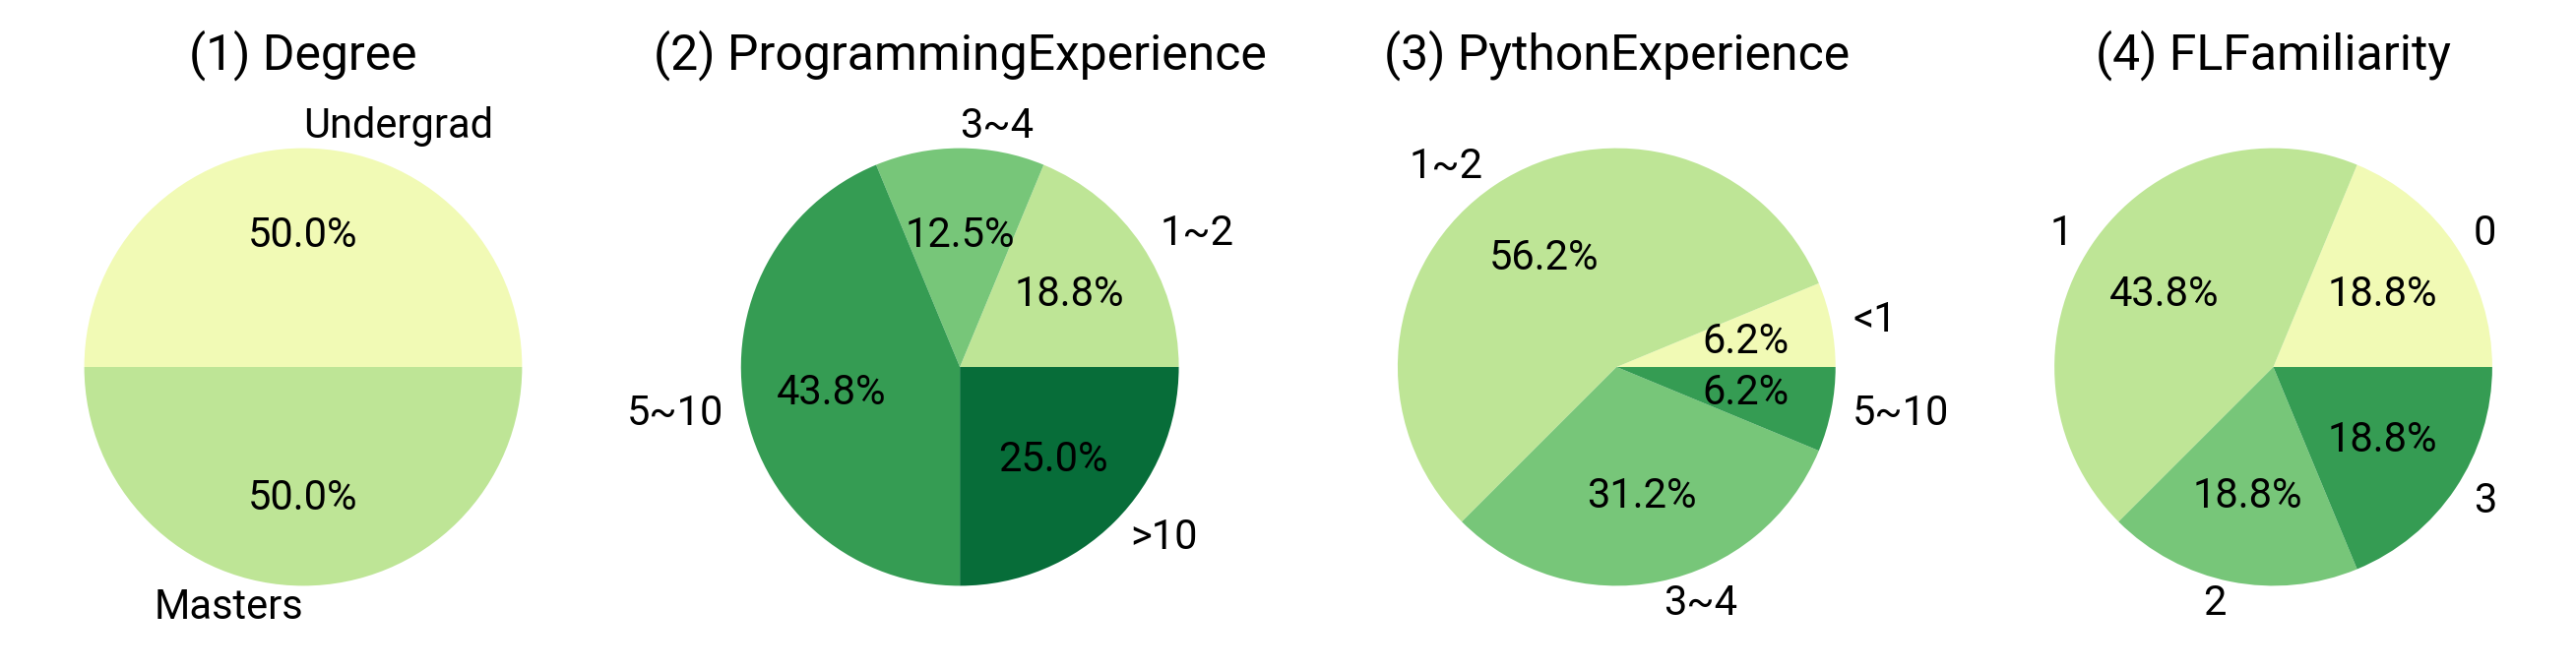

In [9]:

demo_cmap = plt.get_cmap('YlGn')(np.linspace(0.15, 0.85, 5))

value = {
    "Masters": 1,
    "Undergrad": 0,
    "<1": 0,
    "1~2": 1,
    "3~4": 2,
    "5~10": 3,
    ">10": 4,
    0: 0,
    1: 1,
    2: 2,
    3: 3
}

plt.figure(figsize=(11, 3))

for i, column in enumerate(demo.columns):
    value_counts = demo[column].value_counts().to_dict()
    value_counts = {k:value_counts[k] for k in sorted(value_counts, key=lambda k: value[k])}
    print(value_counts)
    plt.subplot(1, len(demo.columns), i+1)
    plt.title(f"({i+1}) {column}")
    plt.pie(value_counts.values(), labels=value_counts.keys(), autopct='%1.1f%%',
            colors=[demo_cmap[value[k]] for k in value_counts]
    )
    
plt.savefig(f"./figures/RQ4_survey_demographic.pdf", bbox_inches="tight")
plt.show()